In [1]:
import sys
sys.path.append('../..')
from TO.utils import check_package_status
check_package_status()

from experiments.utils import set_plt_template
set_plt_template()

<div class="alert alert-block alert-success" style="font-size: 14px; border-radius: 10px"><h4>[GO] TO @ 2507d7e13867b8bfb92d7b5cdd6aa92e6b27ca2c
</h4><pre>  ✅ No changes found in the ./TO packge.</pre></div>

In [2]:
from TO import Topology
from TO.parameterizations.mmc import StraightBeam, MMCAngularConfig, sample_equidistant_pts, Capsules, MMCEndpointsConfig
from TO.problems.beam import create_horizontal_cantilever_problem
from TO.experiment import run_experiment

import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
from tqdm import trange
from IPython.utils.io import capture_output

In [ ]:
class GuoBeam(StraightBeam):
    dimension: int = 5

    def __init__(self, n_samples: int) : self.n_samples = n_samples

    def get_normalization_factors(self, topology: Topology, symmetry_x: bool, symmetry_y: bool) :
        self.rnorm = np.hypot(topology.domain_size_x, topology.domain_size_y)/2
        # we normalize r1 and r2 as it is -> 0-1 instead of rnorm
        # and b -> [-2, 2]
        return np.array([1, 1, self.rnorm, 4, np.pi])

    def transform_pre_scale_y(self, geo: Polygon, config: MMCAngularConfig, x_scaled: np.ndarray):
        (r_left, r_right, a, b, phi) = x_scaled.flatten()
        (a, b, phi) = (a-self.rnorm/2, b-2, phi-np.pi/2)

        # let's linearly map 0-1 to 0.25-4 * config.ry

        r_left = ((4 - 0.25)*r_left + 0.25) * config.ry
        r_right = ((4 - 0.25)*r_right + 0.25) * config.ry

        (x, y) = sample_equidistant_pts(np.c_[geo.exterior.xy], self.n_samples).T

        ry = (r_left + r_right - 2*config.ry) / 2 * (x/config.rx)**2 + (r_right - r_left)/2 * (x/config.rx) + config.ry
        f = a*np.sin(b*(x/config.rx + phi))
        y = (f + ry*y)/config.ry
        
        return Polygon(np.c_[x, y]).buffer(1e-2)

In [4]:
topology = Topology(continuous=True, domain=box(0, 0, 100, 50), density=1.)

parameterization = Capsules(topology, 
    symmetry_x=False, symmetry_y=True, 
    n_components=1, n_samples=1000, 
    representation=MMCEndpointsConfig, 
    transformer=GuoBeam(n_samples=1000)
)

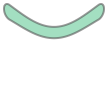

In [5]:
x = np.zeros((parameterization.n_components, parameterization.dimnesion_per_mmc))
x[0] = (0, 0, 1, 0, .1) + (.3, .3, .8, 1, .75)
# very artistic
parameterization.compute_geometry(x)

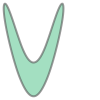

In [6]:
x[0] = (.4, 0, .6, 0, .1) + (.3, .3, .8, 1, .75)
# very artistic
parameterization.compute_geometry(x)

In [7]:
best_configs = []
for i in trange(3):
    with capture_output():
        problem = create_horizontal_cantilever_problem(topology, parameterization)
        run_experiment(problem, budget=500, sigma0=0.25, seed=i+1, name='notebook-rescaling')
        best_configs.append((problem.score_best, problem.x_best))

100%|██████████| 3/3 [05:29<00:00, 109.77s/it]


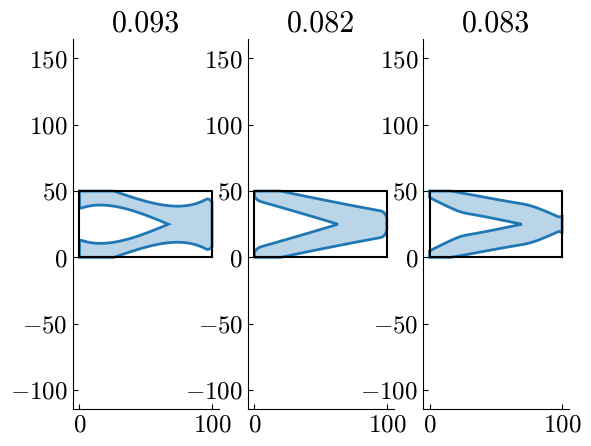

In [8]:
fig, ax = plt.subplots(1, 3)

for j, (score, x) in enumerate(best_configs) :
    parameterization.update_topology(topology, x)
    topology.plot(ax[j]); ax[j].set_title(f'{score:.3f}')